In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [4]:
!pip install --upgrade git+https://github.com/titu1994/tfdiffeq.git 

  Cloning https://github.com/titu1994/tfdiffeq.git to /tmp/pip-req-build-vg839pcm
  Running command git clone -q https://github.com/titu1994/tfdiffeq.git /tmp/pip-req-build-vg839pcm
  Created wheel for tfdiffeq: filename=tfdiffeq-0.0.1-py2.py3-none-any.whl size=43779 sha256=560a26f0a82c5273e26d90201adf16a5502cdb7046458f2821e7e949f1a5e4c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-t3woghey/wheels/1a/fc/26/608bd5ecbf21d23b0e87bb71814d3c031b7c8a5b37fa7aa904
Successfully built tfdiffeq
  Found existing installation: tfdiffeq 0.0.1
    Uninstalling tfdiffeq-0.0.1:
      Successfully uninstalled tfdiffeq-0.0.1


In [5]:
!pip install pysindy

In [18]:
!wget https://raw.githubusercontent.com/titu1994/keras_novograd/master/tf_novograd.py

--2020-03-08 08:04:49--  https://raw.githubusercontent.com/titu1994/keras_novograd/master/tf_novograd.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6082 (5.9K) [text/plain]
Saving to: ‘tf_novograd.py.1’

tf_novograd.py.1    100%[===================>]   5.94K  --.-KB/s    in 0s      

2020-03-08 08:04:50 (36.9 MB/s) - ‘tf_novograd.py.1’ saved [6082/6082]



In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
from tfdiffeq import odeint
from tfdiffeq import plot_phase_portrait, plot_vector_field, plot_results
from tfdiffeq.sindy_utils import STRRidge

In [0]:
from tf_novograd import NovoGrad

In [0]:
NUM_SAMPLES = 1000
device = 'cpu:0' # These experiments do not require the GPU. Normally, 'gpu:0' if tf.test.is_gpu_available() else 'cpu:0' should be used.

# Force Float 64
tf.keras.backend.set_floatx('float64')

In [0]:
class LotkaVoltera(tf.keras.Model):
  
  def __init__(self, a, b, c, d, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.b, self.c, self.d = a, b, c, d
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)
    
    dR_dT = self.a * r - self.b * r * f
    dF_dT = -self.c * f + self.d * r * f
    
    return tf.stack([dR_dT, dF_dT])

In [0]:
t = tf.linspace(0., 10., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([1, 1], dtype=tf.float64)

a = 1.5
b = 1
c = 3
d = 1

In [10]:
%%time

with tf.device(device):
  result = odeint(LotkaVoltera(a, b, c, d), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 3.69 s, sys: 58.3 ms, total: 3.75 s
Wall time: 3.66 s


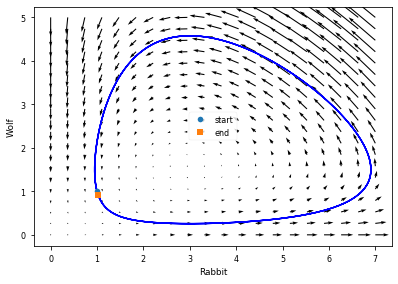

In [11]:
lims = [0, 5]
plot_phase_portrait(LotkaVoltera(a, b, c, d), xlabel='Rabbit', ylabel='Wolf', xlims=[0, 7], ylims=lims)
plot_vector_field(result, xlabel='Rabbit', ylabel='Wolf')

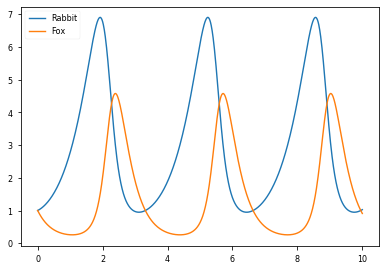

In [12]:
plot_results(t, result, labels=['Rabbit', 'Fox'])

# Now lets try to reconstruct the equations with NNs

In [0]:
class LotkaVolteraTrainable(tf.keras.Model):
  
  def __init__(self, a, b, c, d, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.c = a, c

    self.eqn = tf.keras.Sequential([
             tf.keras.layers.Dense(32, activation=tf.nn.swish, input_shape=(2,)),
             tf.keras.layers.Dense(32, activation=tf.nn.swish,),
             tf.keras.layers.Dense(32, activation=tf.nn.swish),
             tf.keras.layers.Dense(2, activation='relu',)   
    ])
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)

    # Neural ODE component
    n_out = self.eqn(tf.reshape(y, [1, 2]))  # [1, 2] -> [1, 2]
    pred1 = n_out[0, 0]
    pred2 = n_out[0, 1]
    
    dR_dT = self.a * r - pred1
    dF_dT = -self.c * f + pred2
    
    return tf.stack([dR_dT, dF_dT])

In [0]:
t_train = tf.linspace(0., 3., num=30)  # Train for just 3 seconds of input
initial_states_train = tf.convert_to_tensor([1, 1], dtype=tf.float64)

a = 1.5
b = 1
c = 3
d = 1

epochs = 500
initial_learning_rate = 0.01
decay_steps = 100
decay_rate = 0.5

# Train a model
Note: This requires a lot of time ! Suggested to download weights from link below and add to a folder on Colab called "model_weights".

In [0]:
%%time

with tf.device(device):
  model = LotkaVolteraTrainable(a, b, c, d)

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  print("Computing ground truth...")
  y_real = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()

# Save your weights and download them !

In [0]:
model.save_weights('model_weights/ckpt', save_format='tf')

# Load a new model and load these weights (if you didnt train above)

In [0]:
import os
import requests

def get_checkpoints():
  if not os.path.exists('model_weights'):
      os.makedirs('model_weights')

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/checkpoint')
  with open('./model_weights/checkpoint', 'wb') as f:
    f.write(r.content)

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/ckpt.data-00000-of-00001')
  with open('./model_weights/ckpt.data-00000-of-00001', 'wb') as f:
    f.write(r.content)

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/ckpt.index')
  with open('./model_weights/ckpt.index', 'wb') as f:
    f.write(r.content)
  
  print("Pretrained checkpoints retrieved !")

In [51]:
get_checkpoints()

Pretrained checkpoints retrieved !


In [52]:
model = LotkaVolteraTrainable(a, b, c, d)
model.load_weights('model_weights/ckpt')

# Finetune model for 1000+ epochs with low learnign rate

This step takes a lot of time and is quite necessary. We need a loss < 0.05 for good results on finding the exact equation from the neural ODE approximate.

For now, we skip this step and load pretrained weights

In [0]:
epochs = 1000

In [0]:
%%time

with tf.device(device):
  # model = LotkaVolteraTrainable(a, b, c, d)

  optimizer = NovoGrad(1e-4, beta_2=0.5)

  print("Computing ground truth...")
  y_real = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", optimizer.learning_rate.numpy())
    print()

In [0]:
model.save_weights('model_weights/ckpt', save_format='tf')

In [53]:
model = LotkaVolteraTrainable(a, b, c, d)
model.load_weights('model_weights/ckpt')

# Lets interpolate with our approximate universal ODE !

With a trained Neural ODE that appxoximates the Lotka Voltera system with just 30 samples, lets interpolate within the same timeframe to get a fine solution to the coarse approximate.

In [31]:
%%time

t_eval = tf.linspace(0., 3, num=1000)  # Re-evaluate for just 3 seconds of input, but 1000 timesteps

with tf.device(device):
    model_results = odeint(model, initial_states, t_eval)
    real_results = odeint(LotkaVoltera(a, b, c, d), initial_states, t_eval)

CPU times: user 4.12 s, sys: 29.9 ms, total: 4.15 s
Wall time: 4.05 s


# Plot the ODE approximation !

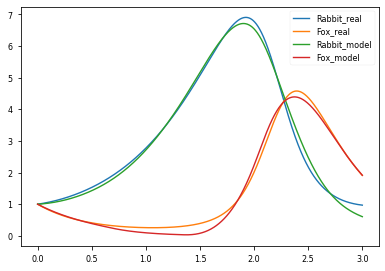

In [32]:
plot_results(t_eval, real_results, labels=['Rabbit_real', 'Fox_real'])
plot_results(t_eval, model_results, labels=['Rabbit_model', 'Fox_model'])

# Lets try and obtain the underlying equations of this system

In [0]:
real_results_np = real_results.numpy()
model_preds_np = model_results.numpy()
t_eval_np = t_eval.numpy()

In [0]:
from pysindy import SINDy
from pysindy.feature_library.polynomial_library import PolynomialLibrary

# Import the nice optimizer for Lasso regression !
from tfdiffeq.sindy_utils import STRRidge

# Optimize hyper parameters of SRTRidge and the Polynomial Library

In [0]:
sindy_optm = STRRidge(threshold=0.5, alpha=1.0)
sindy_library = PolynomialLibrary(degree=10, include_interaction=True,  interaction_only=True)

# Lets fit the SInDy model !

SInDy is short for "Sparse Identification of Non-linear Dynamical Systems" from the paper [Discovering governing equations from data by sparse identification of nonlinear dynamical systems](https://www.pnas.org/content/113/15/3932)

In [36]:
sindy_model = SINDy(optimizer=sindy_optm, feature_library=sindy_library, discrete_time=False)
sindy_model.fit(model_preds_np, t_eval_np)

SINDy(differentiation_method=<pysindy.differentiation.finite_difference.FiniteDifference object at 0x7efdaa7cdc88>,
      discrete_time=False,
      feature_library=PolynomialLibrary(degree=10, include_bias=True,
                                        include_interaction=True,
                                        interaction_only=True, order='C'),
      feature_names=['x0', 'x1'], n_jobs=1,
      optimizer=SRTRidge(alpha=1.0, copy_X=True, fit_intercept=False,
                         lasso_kw=None, max_iter=20, normalize=False,
                         threshold=0.5))

# Lets compare with the original equations

>$\frac{\partial R}{\partial T} = aR - bRF \\ \frac{\partial F}{\partial T} = -cF + dRF$

Recall, $a=1.5$, $b=1$, $c=3.0$, $d=1$

We substitute $bRF$ with $U_1(R, F)$ in $\frac{\partial R}{\partial T}$.

We substitute $dRF$ with $U_2(R, F)$ in $\frac{\partial F}{\partial T}$.

--------

We compare the above two equations with the one printed below.

We get $a'=1.225$ which is quite far off from $a=1.5$, $c'=3.031$, close to the original $c=3.0$.

The equation below approximates $b'=0.838$, far from the $b=1$ we expect. $d'=0.952$ is a closer approximate to our original $d=1$.


In [38]:
sindy_model.print()

x0' = 1.225 x0 + -0.838 x0 x1
x1' = -3.021 x1 + 0.952 x0 x1


In [39]:
sindy_model.coefficients()

array([[ 0.        ,  1.22513333,  0.        , -0.83846648],
       [ 0.        ,  0.        , -3.02139341,  0.95196837]])

In [40]:
sindy_model.equations()

['1.225 x0 + -0.838 x0 x1', '-3.021 x1 + 0.952 x0 x1']

# Compute the $R^2$ score 

In [41]:
sindy_model.score(model_preds_np, t_eval_np)  # 

0.9462645264471189

# Finally, lets extrapolate the derived ODE !

In [54]:
%%time

a_dash = 1.225
b_dash = 0.838
c_dash = 3.021
d_dash = 0.952

t_extrapolate = tf.linspace(0., 10.0, num=1000)  # Train for just 3 seconds of input
initial_states_extrapolate = tf.convert_to_tensor([1, 1], dtype=tf.float64)

with tf.device(device):
    extrapolation_model = LotkaVoltera(a_dash, b_dash, c_dash, d_dash)
    extrapolated_results = odeint(extrapolation_model, initial_states_extrapolate, t_extrapolate)
    real_results = odeint(LotkaVoltera(a, b, c, d), initial_states_extrapolate, t_extrapolate)

CPU times: user 7.23 s, sys: 75.3 ms, total: 7.31 s
Wall time: 7.02 s


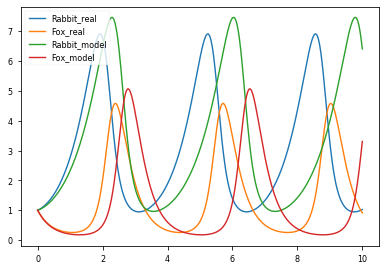

In [55]:
plot_results(t_extrapolate, real_results, labels=['Rabbit_real', 'Fox_real'])
plot_results(t_extrapolate, extrapolated_results, labels=['Rabbit_model', 'Fox_model'])

# As an experiment

Lets overrule the computations for `a` and `c` coefficients since we can obtain them directly from observed experiments. In that case, lets compare results of just the coefficients `b` and `d` on the lag

In [58]:
%%time

a_dash = 1.5  # From direct observations
b_dash = 0.838
c_dash = 3.0  # From direct observations
d_dash = 0.952

t_extrapolate = tf.linspace(0., 10.0, num=1000)  # Train for just 3 seconds of input
initial_states_extrapolate = tf.convert_to_tensor([1, 1], dtype=tf.float64)

with tf.device(device):
    extrapolation_model = LotkaVoltera(a_dash, b_dash, c_dash, d_dash)
    extrapolated_results = odeint(extrapolation_model, initial_states_extrapolate, t_extrapolate)
    real_results = odeint(LotkaVoltera(a, b, c, d), initial_states_extrapolate, t_extrapolate)

CPU times: user 7.47 s, sys: 86.5 ms, total: 7.55 s
Wall time: 7.23 s


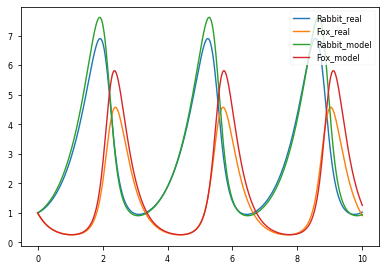

In [59]:
plot_results(t_extrapolate, real_results, labels=['Rabbit_real', 'Fox_real'], figsize=(10,16))
plot_results(t_extrapolate, extrapolated_results, labels=['Rabbit_model', 'Fox_model'], figsize=(10,16))
plt.title("Universal Differential Equation for Lotka-Volterra")
plt.xlabel('Time')
plt.ylabel('Population')
plt.savefig('universal_ode.png', dpi=300)